In [19]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.express as px
from tqdm import tqdm

In [12]:
data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())

size = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(size - size * 0.2), int(size * 0.2)])

batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 307kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.77MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.29MB/s]


In [13]:
class Encoder(nn.Module):

	def __init__(self, encoded_space_dim, fc2_input_dim, in_channels=1):
		super().__init__()

		### Convolutional section
		self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
					  out_channels=8,
					  kernel_size=3,
					  stride=2,
					  padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
		)

		### Flatten layer
		self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
		self.encoder_lin = nn.Sequential(
			nn.Linear(3 * 3 * 32, 128),
			nn.ReLU(True),
			nn.Linear(128, encoded_space_dim)
		)

	def forward(self, x):
		x = self.encoder_cnn(x)
		x = self.flatten(x)
		x = self.encoder_lin(x)
		return x
	

class Decoder(nn.Module):

	def __init__(self, encoded_space_dim, fc2_input_dim):
		super().__init__()
		self.decoder_lin = nn.Sequential(
			nn.Linear(encoded_space_dim, 128),
			nn.ReLU(True),
			nn.Linear(128, 3 * 3 * 32),
			nn.ReLU(True)
		)

		self.unflatten = nn.Unflatten(dim=1,
		unflattened_size=(32, 3, 3))

		self.decoder_conv = nn.Sequential(
			nn.ConvTranspose2d(32, 16, 3,
			stride=2, output_padding=0),
			nn.BatchNorm2d(16),
			nn.ReLU(True),
			nn.ConvTranspose2d(16, 8, 3, stride=2,
			padding=1, output_padding=1),
			nn.BatchNorm2d(8),
			nn.ReLU(True),
			nn.ConvTranspose2d(8, 1, 3, stride=2,
			padding=1, output_padding=1)
		)

	def forward(self, x):
		x = self.decoder_lin(x)
		x = self.unflatten(x)
		x = self.decoder_conv(x)
		x = torch.sigmoid(x)
		return x


In [26]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 10

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
	{'params': encoder.parameters()},
	{'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
print(optim)
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [15]:
def add_noise(inputs,noise_factor=0.3):
	noisy = inputs+torch.randn_like(inputs) * noise_factor
	noisy = torch.clip(noisy,0.,1.)
	return noisy


In [16]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
	# Set train mode for both the encoder and the decoder
	encoder.train()
	decoder.train()
	train_loss = []
	# Iterate the dataloader (we do not need the label values, this is unsupervised learning)
	for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
		# Move tensor to the proper device
		image_noisy = add_noise(image_batch,noise_factor)
		image_batch = image_batch.to(device)
		image_noisy = image_noisy.to(device)
		# Encode data
		encoded_data = encoder(image_noisy)
		# Decode data
		decoded_data = decoder(encoded_data)
		# Evaluate loss
		loss = loss_fn(decoded_data, image_batch)
		# Backward pass
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		# Print batch loss
		print('\t partial train loss (single batch): %f' % (loss.data))
		train_loss.append(loss.detach().cpu().numpy())

	return np.mean(train_loss)


In [17]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
	# Set evaluation mode for encoder and decoder
	encoder.eval()
	decoder.eval()
	with torch.no_grad(): # No need to track the gradients
		# Define the lists to store the outputs for each batch
		conc_out = []
		conc_label = []
		for image_batch, _ in dataloader:
			# Move tensor to the proper device
			image_noisy = add_noise(image_batch,noise_factor)
			image_noisy = image_noisy.to(device)
			# Encode data
			encoded_data = encoder(image_noisy)
			# Decode data
			decoded_data = decoder(encoded_data)
			# Append the network output and the original image to the lists
			conc_out.append(decoded_data.cpu())
			conc_label.append(image_batch.cpu())
		# Create a single tensor with all the values in the lists
		conc_out = torch.cat(conc_out)
		conc_label = torch.cat(conc_label)
		# Evaluate global loss
		val_loss = loss_fn(conc_out, conc_label)
	return val_loss.data


In [18]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
	plt.figure(figsize=(16,4.5))
	targets = test_dataset.targets.numpy()
	t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
	for i in range(n):

		ax = plt.subplot(3,n,i+1)
		img = test_dataset[t_idx[i]][0].unsqueeze(0)
		image_noisy = add_noise(img,noise_factor)
		image_noisy = image_noisy.to(device)

		encoder.eval()
		decoder.eval()

		with torch.no_grad():
			rec_img = decoder(encoder(image_noisy))

		plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Original images')
		ax = plt.subplot(3, n, i + 1 + n)
		plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Corrupted images')

		ax = plt.subplot(3, n, i + 1 + n + n)
		plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Reconstructed images')
	plt.subplots_adjust(left=0.1,
					bottom=0.1,
					right=0.7,
					top=0.9,
					wspace=0.3,
					hspace=0.3)
	plt.show()


In [27]:
type(optim)

torch.optim.adam.Adam

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1/10
	 partial train loss (single batch): 0.315094
	 partial train loss (single batch): 0.305426
	 partial train loss (single batch): 0.299326
	 partial train loss (single batch): 0.293880
	 partial train loss (single batch): 0.288378
	 partial train loss (single batch): 0.285054
	 partial train loss (single batch): 0.280503
	 partial train loss (single batch): 0.276984
	 partial train loss (single batch): 0.273245
	 partial train loss (single batch): 0.270910
	 partial train loss (single batch): 0.267556
	 partial train loss (single batch): 0.264387
	 partial train loss (single batch): 0.260748
	 partial train loss (single batch): 0.259046
	 partial train loss (single batch): 0.256975
	 partial train loss (single batch): 0.253841
	 partial train loss (single batch): 0.251217
	 partial train loss (single batch): 0.250385
	 partial train loss (single batch): 0.247575
	 partial train loss (single batch): 0.246493
	 partial train loss (single batch): 0.243421
	 partial train loss (s

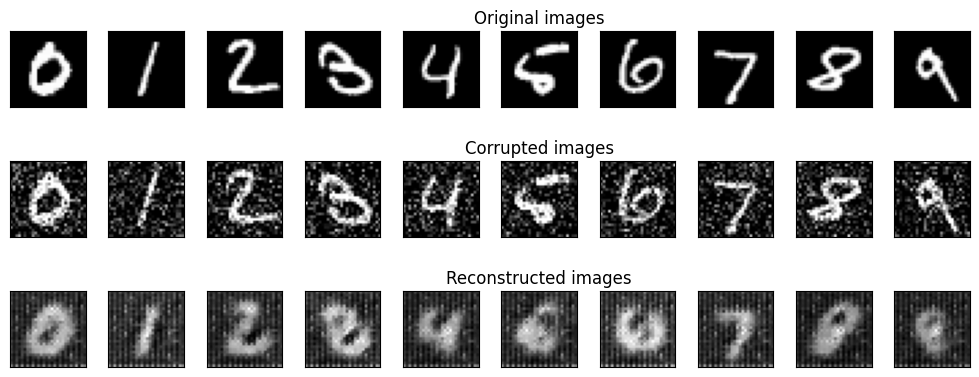

 10%|█         | 1/10 [00:18<02:48, 18.73s/it]

EPOCH 2/10
	 partial train loss (single batch): 0.068520
	 partial train loss (single batch): 0.067606
	 partial train loss (single batch): 0.067232
	 partial train loss (single batch): 0.065723
	 partial train loss (single batch): 0.066404
	 partial train loss (single batch): 0.065189
	 partial train loss (single batch): 0.065529
	 partial train loss (single batch): 0.065126
	 partial train loss (single batch): 0.064832
	 partial train loss (single batch): 0.063963
	 partial train loss (single batch): 0.064254
	 partial train loss (single batch): 0.063285
	 partial train loss (single batch): 0.063773
	 partial train loss (single batch): 0.062793
	 partial train loss (single batch): 0.062087
	 partial train loss (single batch): 0.062360
	 partial train loss (single batch): 0.062051
	 partial train loss (single batch): 0.061274
	 partial train loss (single batch): 0.061086
	 partial train loss (single batch): 0.060834
	 partial train loss (single batch): 0.061239
	 partial train loss (s

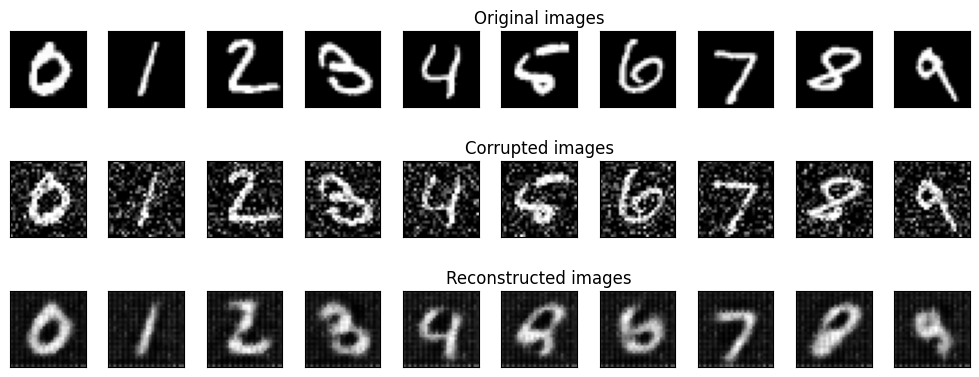

 20%|██        | 2/10 [00:38<02:35, 19.44s/it]

EPOCH 3/10
	 partial train loss (single batch): 0.035327
	 partial train loss (single batch): 0.033979
	 partial train loss (single batch): 0.034469
	 partial train loss (single batch): 0.033291
	 partial train loss (single batch): 0.034164
	 partial train loss (single batch): 0.033174
	 partial train loss (single batch): 0.033932
	 partial train loss (single batch): 0.033480
	 partial train loss (single batch): 0.033329
	 partial train loss (single batch): 0.033148
	 partial train loss (single batch): 0.033688
	 partial train loss (single batch): 0.032950
	 partial train loss (single batch): 0.033346
	 partial train loss (single batch): 0.033340
	 partial train loss (single batch): 0.032725
	 partial train loss (single batch): 0.033684
	 partial train loss (single batch): 0.033016
	 partial train loss (single batch): 0.032594
	 partial train loss (single batch): 0.033376
	 partial train loss (single batch): 0.032505
	 partial train loss (single batch): 0.033542
	 partial train loss (s

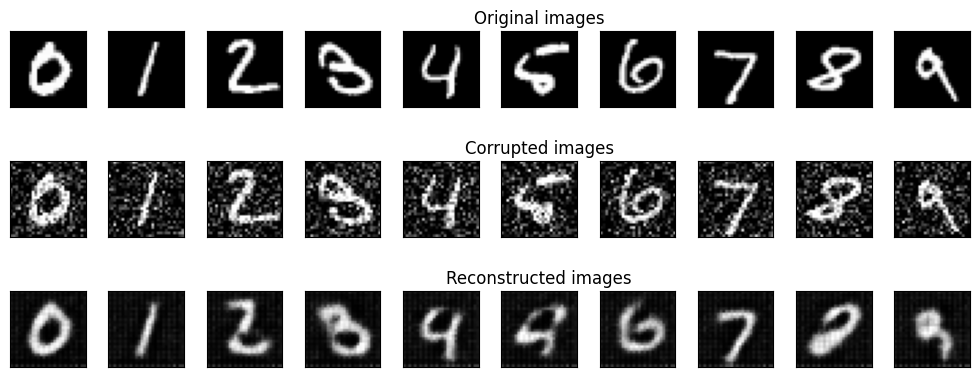

 30%|███       | 3/10 [00:57<02:15, 19.33s/it]

EPOCH 4/10
	 partial train loss (single batch): 0.026955
	 partial train loss (single batch): 0.025932
	 partial train loss (single batch): 0.026259
	 partial train loss (single batch): 0.025503
	 partial train loss (single batch): 0.026342
	 partial train loss (single batch): 0.025269
	 partial train loss (single batch): 0.025942
	 partial train loss (single batch): 0.025858
	 partial train loss (single batch): 0.025710
	 partial train loss (single batch): 0.025661
	 partial train loss (single batch): 0.026220
	 partial train loss (single batch): 0.025301
	 partial train loss (single batch): 0.025632
	 partial train loss (single batch): 0.025920
	 partial train loss (single batch): 0.025392
	 partial train loss (single batch): 0.026337
	 partial train loss (single batch): 0.025316
	 partial train loss (single batch): 0.025125
	 partial train loss (single batch): 0.026091
	 partial train loss (single batch): 0.025407
	 partial train loss (single batch): 0.026299
	 partial train loss (s

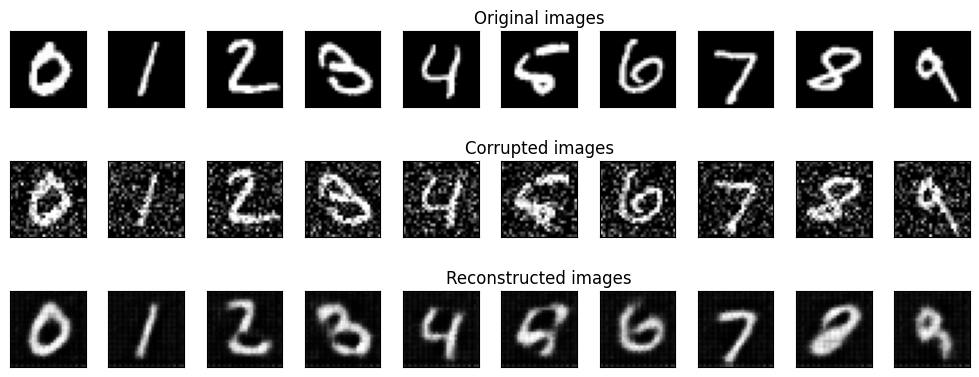

 40%|████      | 4/10 [01:14<01:50, 18.37s/it]

EPOCH 5/10
	 partial train loss (single batch): 0.023728
	 partial train loss (single batch): 0.022779
	 partial train loss (single batch): 0.023297
	 partial train loss (single batch): 0.022058
	 partial train loss (single batch): 0.023129
	 partial train loss (single batch): 0.022031
	 partial train loss (single batch): 0.022910
	 partial train loss (single batch): 0.022269
	 partial train loss (single batch): 0.022436
	 partial train loss (single batch): 0.022574
	 partial train loss (single batch): 0.022803
	 partial train loss (single batch): 0.022134
	 partial train loss (single batch): 0.022366
	 partial train loss (single batch): 0.022658
	 partial train loss (single batch): 0.022253
	 partial train loss (single batch): 0.023255
	 partial train loss (single batch): 0.022446
	 partial train loss (single batch): 0.022093
	 partial train loss (single batch): 0.023188
	 partial train loss (single batch): 0.022293
	 partial train loss (single batch): 0.023267
	 partial train loss (s

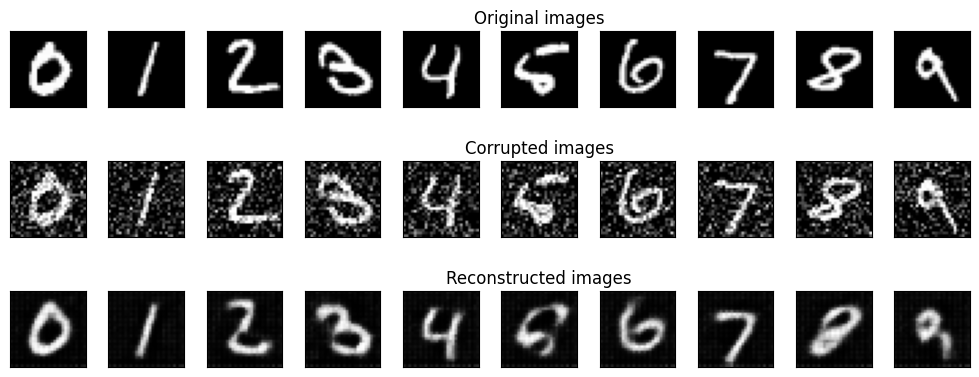

 50%|█████     | 5/10 [01:34<01:35, 19.03s/it]

EPOCH 6/10
	 partial train loss (single batch): 0.021945
	 partial train loss (single batch): 0.020859
	 partial train loss (single batch): 0.021103
	 partial train loss (single batch): 0.020465
	 partial train loss (single batch): 0.021219
	 partial train loss (single batch): 0.020249
	 partial train loss (single batch): 0.021067
	 partial train loss (single batch): 0.020527
	 partial train loss (single batch): 0.020621
	 partial train loss (single batch): 0.020777
	 partial train loss (single batch): 0.020904
	 partial train loss (single batch): 0.020378
	 partial train loss (single batch): 0.020805
	 partial train loss (single batch): 0.020632
	 partial train loss (single batch): 0.020711
	 partial train loss (single batch): 0.021544
	 partial train loss (single batch): 0.020565
	 partial train loss (single batch): 0.020272
	 partial train loss (single batch): 0.021565
	 partial train loss (single batch): 0.020495
	 partial train loss (single batch): 0.021482
	 partial train loss (s

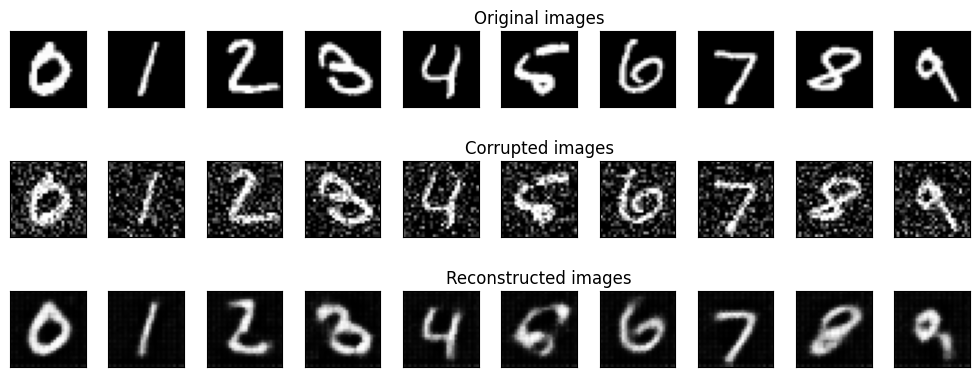

 60%|██████    | 6/10 [01:54<01:16, 19.24s/it]

EPOCH 7/10
	 partial train loss (single batch): 0.020791
	 partial train loss (single batch): 0.019829
	 partial train loss (single batch): 0.019868
	 partial train loss (single batch): 0.019234
	 partial train loss (single batch): 0.020105
	 partial train loss (single batch): 0.018952
	 partial train loss (single batch): 0.019873
	 partial train loss (single batch): 0.019567
	 partial train loss (single batch): 0.019307
	 partial train loss (single batch): 0.019617
	 partial train loss (single batch): 0.019620
	 partial train loss (single batch): 0.019335
	 partial train loss (single batch): 0.019397
	 partial train loss (single batch): 0.019644
	 partial train loss (single batch): 0.019397
	 partial train loss (single batch): 0.020483
	 partial train loss (single batch): 0.019454
	 partial train loss (single batch): 0.019123
	 partial train loss (single batch): 0.020477
	 partial train loss (single batch): 0.019212
	 partial train loss (single batch): 0.020546
	 partial train loss (s

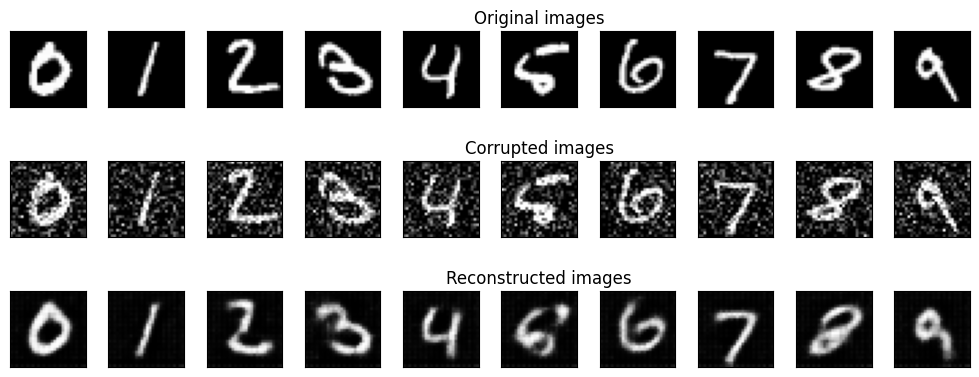

 70%|███████   | 7/10 [02:14<00:58, 19.38s/it]

EPOCH 8/10
	 partial train loss (single batch): 0.020154
	 partial train loss (single batch): 0.018962
	 partial train loss (single batch): 0.019084
	 partial train loss (single batch): 0.018470
	 partial train loss (single batch): 0.019190
	 partial train loss (single batch): 0.018277
	 partial train loss (single batch): 0.019144
	 partial train loss (single batch): 0.018658
	 partial train loss (single batch): 0.018622
	 partial train loss (single batch): 0.018840
	 partial train loss (single batch): 0.018714
	 partial train loss (single batch): 0.018659
	 partial train loss (single batch): 0.018611
	 partial train loss (single batch): 0.018784
	 partial train loss (single batch): 0.018510
	 partial train loss (single batch): 0.019680
	 partial train loss (single batch): 0.018492
	 partial train loss (single batch): 0.018284
	 partial train loss (single batch): 0.019682
	 partial train loss (single batch): 0.018377
	 partial train loss (single batch): 0.019486
	 partial train loss (s

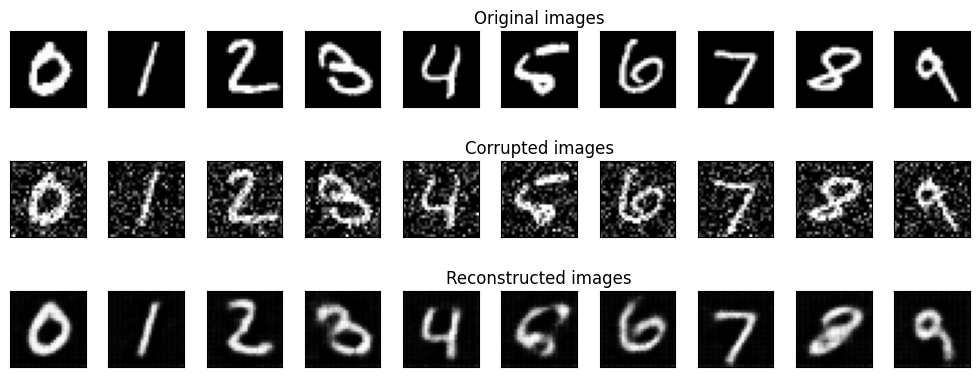

 80%|████████  | 8/10 [02:34<00:39, 19.73s/it]

EPOCH 9/10
	 partial train loss (single batch): 0.019150
	 partial train loss (single batch): 0.018356
	 partial train loss (single batch): 0.018395
	 partial train loss (single batch): 0.017837
	 partial train loss (single batch): 0.018603
	 partial train loss (single batch): 0.017454
	 partial train loss (single batch): 0.018461
	 partial train loss (single batch): 0.018003
	 partial train loss (single batch): 0.017947
	 partial train loss (single batch): 0.018413
	 partial train loss (single batch): 0.018042
	 partial train loss (single batch): 0.017968
	 partial train loss (single batch): 0.018083
	 partial train loss (single batch): 0.018250
	 partial train loss (single batch): 0.017997
	 partial train loss (single batch): 0.019150
	 partial train loss (single batch): 0.017977
	 partial train loss (single batch): 0.017780
	 partial train loss (single batch): 0.019219
	 partial train loss (single batch): 0.017631
	 partial train loss (single batch): 0.019023
	 partial train loss (s

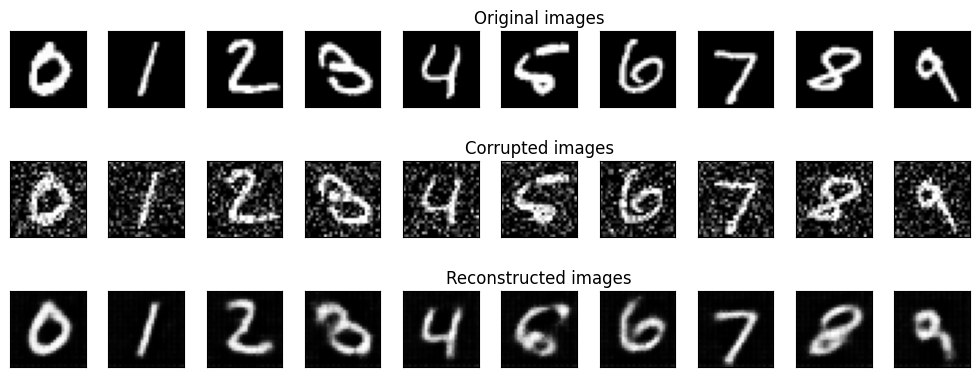

 90%|█████████ | 9/10 [02:52<00:19, 19.09s/it]

EPOCH 10/10
	 partial train loss (single batch): 0.018551
	 partial train loss (single batch): 0.017721
	 partial train loss (single batch): 0.017650
	 partial train loss (single batch): 0.017375
	 partial train loss (single batch): 0.018000
	 partial train loss (single batch): 0.017172
	 partial train loss (single batch): 0.017951
	 partial train loss (single batch): 0.017292
	 partial train loss (single batch): 0.017233
	 partial train loss (single batch): 0.017751
	 partial train loss (single batch): 0.017629
	 partial train loss (single batch): 0.017436
	 partial train loss (single batch): 0.017470
	 partial train loss (single batch): 0.017789
	 partial train loss (single batch): 0.017467
	 partial train loss (single batch): 0.018535
	 partial train loss (single batch): 0.017375
	 partial train loss (single batch): 0.017251
	 partial train loss (single batch): 0.018500
	 partial train loss (single batch): 0.017246
	 partial train loss (single batch): 0.018338
	 partial train loss (

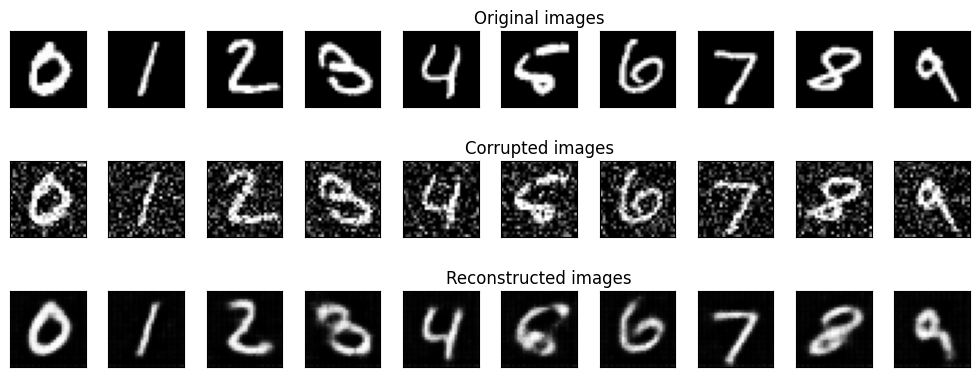

100%|██████████| 10/10 [03:14<00:00, 19.43s/it]


In [28]:
### Training cycle
noise_factor = 0.3
num_epochs = 10
history_da={'train_loss':[],'val_loss':[]}

for epoch in tqdm(range(num_epochs)):
	print('EPOCH %d/%d' % (epoch + 1, num_epochs))
	### Training (use the training function)
	train_loss=train_epoch_den(
		encoder=encoder,
		decoder=decoder,
		device=device,
		dataloader=train_loader,
		loss_fn=loss_fn,
		optimizer=optim,
		noise_factor=noise_factor)
	### Validation (use the testing function)
	val_loss = test_epoch_den(
		encoder=encoder,
		decoder=decoder,
		device=device,
		dataloader=valid_loader,
		loss_fn=loss_fn,noise_factor=noise_factor)
	# Print Validationloss
	history_da['train_loss'].append(train_loss)
	history_da['val_loss'].append(val_loss)
	print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
	plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)


In [31]:
iter(test_loader)

tensor([-0.4361,  0.2619,  0.4756, -0.4222,  0.1241,  0.6891, -0.0425, -0.2944,
        -0.1581, -0.3663])
tensor([0.4128, 0.6464, 0.3567, 0.5552, 0.5284, 0.3374, 0.5766, 0.3875, 0.4767,
        0.5293])


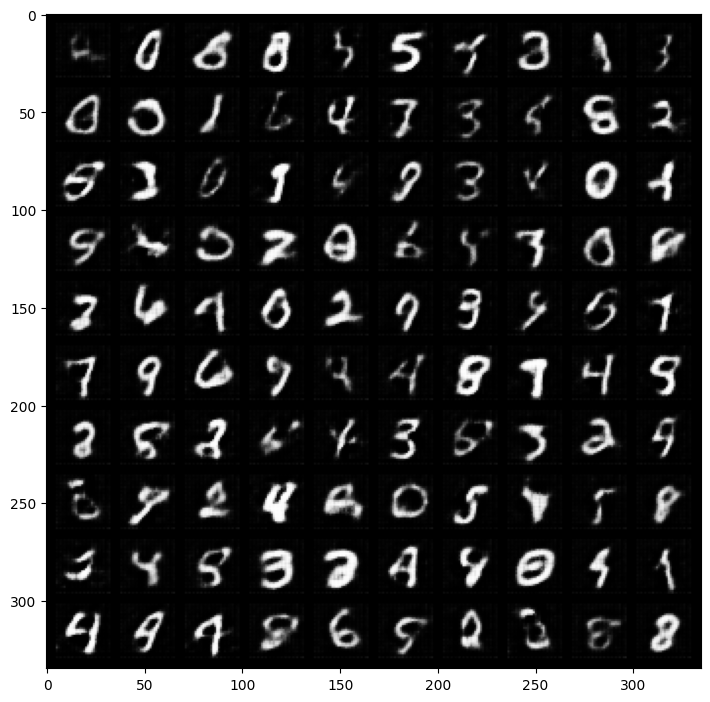

In [32]:
def show_image(img):
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
	# calculate mean and std of latent code, generated takining in test images as inputs
	images, labels = next(iter(test_loader))
	images = images.to(device)
	latent = encoder(images)
	latent = latent.cpu()

	mean = latent.mean(dim=0)
	print(mean)
	std = (latent - mean).pow(2).mean(dim=0).sqrt()
	print(std)

	# sample latent vectors from the normal distribution
	latent = torch.randn(128, d)*std + mean

	# reconstruct images from the random latent vectors
	latent = latent.to(device)
	img_recon = decoder(latent)
	img_recon = img_recon.cpu()

	fig, ax = plt.subplots(figsize=(20, 8.5))
	show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
	plt.show()


In [33]:
encoded_samples = []

for sample in tqdm(test_dataset):
	img = sample[0].unsqueeze(0).to(device)
	label = sample[1]
	# Encode image
	encoder.eval()
	
	with torch.no_grad():
		encoded_img = encoder(img) # Append to list

	encoded_img = encoded_img.flatten().cpu().numpy()
	encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
	encoded_sample['label'] = label
	encoded_samples.append(encoded_sample)
	
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


100%|██████████| 10000/10000 [00:06<00:00, 1442.99it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,label
0,-0.667494,-0.360504,0.291740,-0.400694,0.054958,0.137613,0.245058,0.195847,-0.979668,-0.330595,7
1,0.174361,0.927565,0.532672,0.614189,0.638282,0.818061,-1.031363,-1.161771,0.556973,-0.745244,2
2,-0.329314,-0.721244,0.398183,0.485169,-0.121479,0.835560,-0.269591,-0.165091,0.674555,0.066017,1
3,-1.440887,1.065187,0.222389,-0.815708,0.943466,0.655897,0.342709,-0.614496,-0.309012,-0.674579,0
4,-0.431873,0.308499,0.726350,-1.058469,0.351649,0.289649,-0.137260,-0.353718,-0.236908,0.552089,4
...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.072273,0.017357,1.222748,0.564379,1.228848,0.873031,-0.079263,-0.089225,-0.242994,-0.635760,2
9996,-0.714102,0.475165,0.192291,0.318300,0.296435,0.946919,-0.869515,-0.502077,-0.495022,-1.293108,3
9997,-1.033909,-0.238472,0.763682,-0.434275,-0.466677,1.166373,0.149720,0.265224,0.066942,0.188640,4
9998,-0.072256,0.208926,-0.028830,-0.443504,-0.323891,1.031012,0.828971,-0.550776,-0.475742,-0.350216,5


In [34]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
		   color=encoded_samples.label.astype(str), opacity=0.7)


In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
				 color=encoded_samples.label.astype(str),
				 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()
